### III- Analyse modèle de Random Forest 

In [2]:
import pyarrow.parquet as pq
import pyarrow as pa
import pandas as pd
import sys
import os

print("Current working directory:", os.getcwd())

sys.path.append(os.path.abspath('..'))
print("Updated sys.path:", sys.path)
from fonctions import defined_X_y
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from skopt.space import Real,Integer,Categorical
from skopt import BayesSearchCV
from timeit import default_timer as timer
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

Current working directory: c:\Users\lulil\OneDrive\Documents\SCORING-TIDE\modélisation
Updated sys.path: ['c:\\Users\\lulil\\OneDrive\\Documents\\SCORING-TIDE\\modélisation', 'c:\\Users\\lulil\\anaconda3\\python39.zip', 'c:\\Users\\lulil\\anaconda3\\DLLs', 'c:\\Users\\lulil\\anaconda3\\lib', 'c:\\Users\\lulil\\anaconda3', '', 'C:\\Users\\lulil\\AppData\\Roaming\\Python\\Python39\\site-packages', 'c:\\Users\\lulil\\anaconda3\\lib\\site-packages', 'c:\\Users\\lulil\\anaconda3\\lib\\site-packages\\win32', 'c:\\Users\\lulil\\anaconda3\\lib\\site-packages\\win32\\lib', 'c:\\Users\\lulil\\anaconda3\\lib\\site-packages\\Pythonwin', 'c:\\Users\\lulil\\OneDrive\\Documents\\SCORING-TIDE']


In [3]:
table = pq.read_table('../data/train_dummies_data.parquet')
t = pq.read_table('../data/test_dummies_data.parquet')
train_df = table.to_pandas()
test_df = t.to_pandas()

In [4]:
X_train, y_train = defined_X_y(train_df, 'fraude')
X_test, y_test = defined_X_y(test_df, 'fraude')

1. Random Forest

In [5]:
param_dict_bayes_RF = {
    'n_estimators' : Integer(10,200),
    'criterion': Categorical(['gini', 'entropy']), 
    'max_depth': Integer(2,10),
    'bootstrap':Categorical([True,False])}

In [6]:
#recherche des hyperparèmetres optimaux

opt = BayesSearchCV(RandomForestClassifier(),param_dict_bayes_RF,n_iter=5,cv=3,scoring = 'roc_auc',random_state=1)


opt.fit(X_train, y_train)
best_param_opti_bayes =opt.best_params_
best_score_opti_bayes = opt.best_score_
all_result_opti_bayes = opt.cv_results_
print(" #### RECHERCHE DES PARAMETRES OPTIMAUX POUR LE RANDOM FOREST #### ")
print("\n Paramètres optimaux : ")
best_param_opti_bayes =opt.best_params_
print(best_param_opti_bayes)
best_score_opti_bayes = opt.best_score_
print("\n Résultats  : " + str(best_score_opti_bayes))

 #### RECHERCHE DES PARAMETRES OPTIMAUX POUR LE RANDOM FOREST #### 

 Paramètres optimaux : 
OrderedDict([('bootstrap', False), ('criterion', 'gini'), ('max_depth', 8), ('n_estimators', 63)])

 Résultats  : 0.8184952040727359


In [7]:
rf_clf = RandomForestClassifier(**opt.best_params_)
rf_clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=False, max_depth=8, n_estimators=63)

In [8]:
importance_variable_rf = pd.DataFrame()
importance_variable_rf["Variable"] = X_train.columns
importance_variable_rf["Feature Importance"] = rf_clf.feature_importances_

# Sort the DataFrame by feature importance
importance_variable_rf = importance_variable_rf.sort_values(by="Feature Importance", ascending=False)

# Display the DataFrame
print(importance_variable_rf)

                     Variable  Feature Importance
3                   fm_sum_24            0.191458
2    fm_velocity_condition_24            0.180289
4        fm_redondance_mcc_24            0.065800
0                     coderep            0.058122
154                  pays_792            0.046705
..                        ...                 ...
381                  mcc_3563            0.000000
382                  mcc_3565            0.000000
383                  mcc_3567            0.000000
384                  mcc_3568            0.000000
438                  mcc_3668            0.000000

[876 rows x 2 columns]


# 1. Approche statistique : maximiser un critère tel que l'AUC

`Courbes ROC sur données train`

In [9]:
#pour le test

fpr_test_RF, tpr_test_RF, _ = roc_curve(y_train, rf_clf.predict_proba(X_train)[:,1])
roc_auc_test_RF = auc(fpr_test_RF, tpr_test_RF)

In [11]:
#pour le train

fpr_train_RF, tpr_train_RF, thresholds_train_RF = roc_curve(y_train, rf_clf.predict_proba(X_train)[:,1])
roc_auc_train_RF = auc(fpr_train_RF, tpr_train_RF)


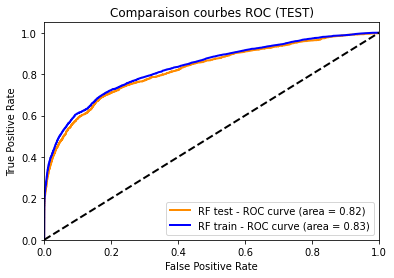

In [13]:
# ROC

lw = 2
# Random Forest

plt.plot(fpr_test_RF, tpr_test_RF, color='darkorange',
         lw=lw, label='RF test - ROC curve (area = %0.2f)' % roc_auc_test_RF)

plt.plot(fpr_train_RF, tpr_train_RF, color='blue',
         lw=lw, label='RF train - ROC curve (area = %0.2f)' % roc_auc_train_RF)


plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparaison courbes ROC (TEST)')
plt.legend(loc="lower right")
plt.show()

In [14]:
print("APP - RF : LogLoss  : " + str(log_loss(y_train, rf_clf.predict_proba(X_train)[:,1])))
print("TEST - RF : LogLoss  : " + str(log_loss(y_test, rf_clf.predict_proba(X_test)[:,1])))

APP - RF : LogLoss  : 0.03254241037789615
TEST - RF : LogLoss  : 0.03161829708027499


# 2. Approche métier : arbitrer utiliser le recall

In [16]:
precision_test_RF,recall_test_RF,thresholds_test_RF = precision_recall_curve(y_test, rf_clf.predict_proba(X_test)[:,1])

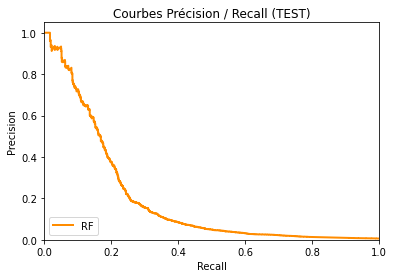

In [17]:
lw = 2
plt.plot(recall_test_RF,precision_test_RF, color='darkorange',
         lw=lw, label='RF')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Courbes Précision / Recall (TEST)')
plt.legend(loc="lower left")
plt.show()

In [18]:
## Choix du seuil - Tableau seuil /
table_choix_seuil = pd.DataFrame()
table_choix_seuil["Seuil"] = [0] + list(thresholds_test_RF)
table_choix_seuil["Precision_test_RF"] = precision_test_RF
table_choix_seuil["Recall_test_RF"] = recall_test_RF
table_choix_seuil.sort_values(by = "Seuil", axis=0, ascending=False, inplace=True)
table_choix_seuil.head(10)

,Seuil,Precision_test_RF,Recall_test_RF
79320,0.200992,1.0,0.000000
79319,0.187455,1.0,0.000720
79318,0.184373,1.0,0.001440
79317,0.176400,1.0,0.002160
79316,0.171048,1.0,0.002880
79315,0.165047,1.0,0.003600
79314,0.163685,1.0,0.004320
79313,0.160945,1.0,0.005040
79312,0.158955,1.0,0.005760
79311,0.157670,1.0,0.006479
